Inspiration & Reference: http://blog.yhathq.com/posts/naive-bayes-in-python.html

## Document collection
This dataset is taken from [20Newsgroups](http://qwone.com/~jason/20Newsgroups/); we only use 2 categories:
```
CATEGORIES
rec.sport.baseball
rec.sport.hockey
```  

In total there is 1993 documents -- we take 60% for training and 40% for testing:

In [1]:
import glob
import pandas as pd

samples = {
    'train':{},
    'test':{}
}

files = glob.glob('20news-bydate-*/rec.sport*/*')
for s in samples.keys():
    for c in ['baseball', 'hockey']:
        samples[s][c] = samples[s].get(c, len(filter(lambda x: s in x and c in x, files)))

print 'Number of training documents:\t', sum(samples['train'].values())
print 'Number of testing documents:\t', sum(samples['test'].values())
pd.DataFrame.from_dict(samples)

Number of training documents:	1197
Number of testing documents:	796


,test,train
baseball,397,597
hockey,399,600


## Model: Naive Bayes
- $P(C|D) = \frac{P(C) P(D|C)}{P(D)}$
- Independence assumption

## Training

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string
import glob
import string
import math
import operator

In [3]:
def count_words(words):
    wc = {}
    for word in words:
        wc[word] = wc.get(word, 0.0) + 1.0
    return wc

table = string.maketrans("","")
stop = stopwords.words("english")
snowballstemmer = SnowballStemmer("english")

def preprocess(f):
    ## will need 'table', 'stop', and 'snowballstemmer' predefined
    text = open(f).read().translate(table, string.punctuation).lower()
    text = filter(lambda x: x in string.printable, text)

    words = nltk.word_tokenize(text)
    words = [i for i in words if i not in stop]
    words = [snowballstemmer.stem(i) for i in words]
    return words

In [4]:
vocab = {}
word_counts = {
    "baseball":{},
    "hockey":{},
}
priors = {
    "baseball":0., 
    "hockey":0.,
}
docs = []

for f in glob.glob('20news-bydate-train/rec.sport*/*'):
    if 'baseball' in f:
        category = 'baseball'
    else:
        category = 'hockey'

    docs.append((category, f))
    priors[category] += 1

    words = preprocess(f)
    counts = count_words(words)
    
    for word, count in counts.items():
        if word not in vocab:
            vocab[word] = 0.0
        if word not in word_counts[category]:
            word_counts[category][word] = 0.0

        vocab[word] += count
        word_counts[category][word] += count

print 'Number of features (i.e. terms): ', len(vocab)

Number of features (i.e. terms):  18211


## Testing

In [5]:
results = {
    "baseball":{
        "idx":0,
        "results":{0:0.0, 1:0.0}
    },
    "hockey":{
        "idx":1,
        "results":{0:0.0, 1:0.0}
    }
}
docfail = []

## P(category)
prior_baseball = priors["baseball"] / sum(priors.values())
prior_hockey = priors["hockey"] / sum(priors.values())

for new_doc in glob.glob('20news-bydate-test/rec.sport*/*'):
    if 'baseball' in new_doc:
        category = 'baseball'
    else:
        category = 'hockey'
    
    words = preprocess(new_doc)
    counts = count_words(words)
    
    ## To prevent computational errors, will perform operations in logspace, log(probabilities)
    log_prob_baseball = 0.0
    log_prob_hockey = 0.0

    for w, cnt in counts.items():
        ## heuristic: skip words not seen before, or words < 3 letters long
        if not w in vocab or len(w) <= 3:
            continue

        ## calculate prob that the word occurs at all
        p_word = vocab[w] / sum(vocab.values())

        ## calculate P(word|category)
        p_w_given_baseball = word_counts["baseball"].get(w, 0.0) / sum(word_counts["baseball"].values())
        p_w_given_hockey = word_counts["hockey"].get(w, 0.0) / sum(word_counts["hockey"].values())

        if p_w_given_baseball > 0:
            log_prob_baseball += math.log(cnt * p_w_given_baseball / p_word)
        if p_w_given_hockey > 0:
            log_prob_hockey += math.log(cnt * p_w_given_hockey / p_word)

    try:
        max_index, max_value = max(enumerate([
                    math.exp(log_prob_baseball + math.log(prior_baseball)), #p_baseball_given_w
                    math.exp(log_prob_hockey + math.log(prior_hockey)), #p_hockey_given_w
                ]),
                                   key=operator.itemgetter(1))
    except:
        docfail.append(new_doc)
        continue
    
    results[category]["results"][max_index] = results[category]["results"].get(max_index, 0.0) + 1.0
        
## OUPUT: documents which fail testing
for i in docfail: print i

In [6]:
print results

{'baseball': {'results': {0: 393.0, 1: 4.0}, 'idx': 0}, 'hockey': {'results': {0: 87.0, 1: 312.0}, 'idx': 1}}


Because I don't want to re-run the training & testing everything time I come back to this project, we will save the result to a file.
````
import json
with open('dc-results/naivebayes2.json', 'w') as out:
    json.dump(results, out)
````

## Visualizing the results

In [7]:
import json
with open('dc-results/naivebayes2.json') as f:
    results = json.load(f)

In [45]:
import pandas as pd
import numpy as np
%load_ext rpy2.ipython
%R library(ggplot2)
%R library(reshape)
%R library(gplots)
%R library('grid')
%R library('gridExtra')
%matplotlib inline
from copy import deepcopy
import matplotlib.pyplot as plt
print

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython



In [9]:
r = {k:v['results'] for k,v in results.iteritems()}
df = pd.DataFrame.from_dict(r)#, orient="index")
df.index = ['predict_baseball', 'predict_hockey']
dfcounts = deepcopy(df)
print dfcounts

if (sum(df.baseball) != 0): df.baseball = df.baseball / sum(df.baseball)
if (sum(df.hockey) != 0): df.hockey = df.hockey / sum(df.hockey)
df

                  baseball  hockey
predict_baseball       393      87
predict_hockey           4     312


,baseball,hockey
predict_baseball,0.989924,0.218045
predict_hockey,0.010076,0.781955


In [10]:
_total = sum(sum(dfcounts.values))
print 'Number of test samples: %d' % _total
print 'Percent of test set labelled correctly: %0.1f%%' % (sum(np.diagonal(dfcounts)) / _total * 100)

Number of test samples: 796
Percent of test set labelled correctly: 88.6%


The size of the test set is 796 documents. Overall, the classifier has an accuracy of 88.6%. 

Using  as id variables


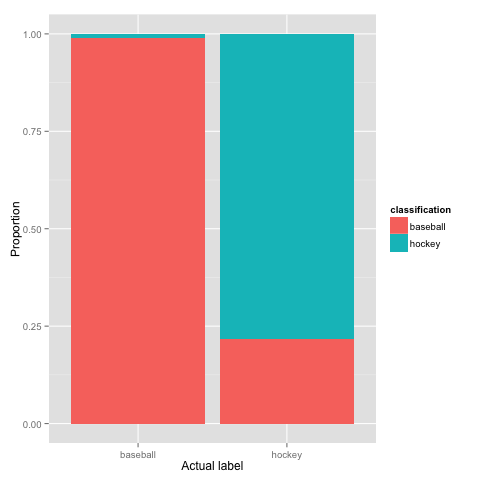

In [11]:
%%R -i df

df = melt(df)
colnames(df) = c("expected", "value")
df = cbind(df, classification=rep(c('baseball', 'hockey'), 2))

ggplot(df, aes(x=expected, y=value, fill=classification)) +
    geom_bar(stat="identity") + 
    xlab("Actual label") +
    ylab("Proportion")

Given the actual labels, we find that our classifier performs well for the baseball labels (99% correct) and okay for the hockey labels (78% correct).

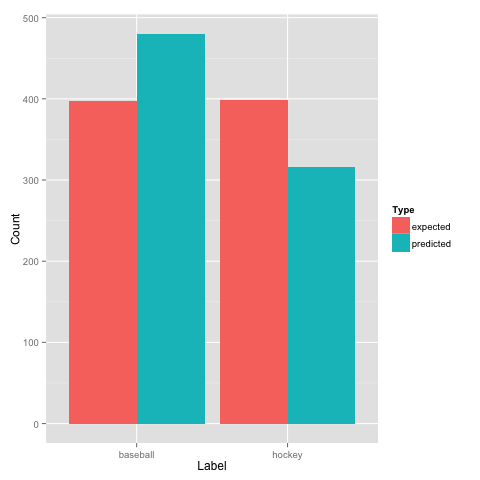

In [12]:
%%R -i dfcounts
dat = cbind(expected=colSums(dfcounts), predicted=rowSums(dfcounts))
dat = melt(dat)
colnames(dat) <- c("Label", "Type", "Count")

ggplot(dat, aes(x=Label, y=Count, fill=Type)) +
    geom_bar(stat="identity", position="dodge")

A possible explanation for why the classifier did so well for classifying "baseball" documents is because the classifier tends to predict more "baseball" than expected.

## Investigating the features

In [17]:
terms_baseball = word_counts['baseball'].keys()
terms_hockey = word_counts['hockey'].keys()

print "Total # terms for baseball: ", len(terms_baseball)
print "Total # terms for hockey: ", len(terms_hockey)

Total # terms for baseball:  9567
Total # terms for hockey:  12614


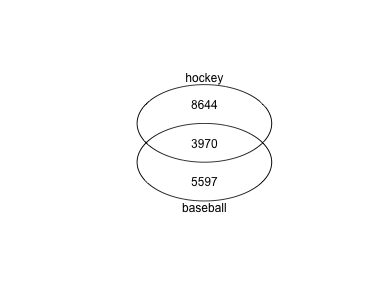

In [18]:
%%R -i terms_baseball,terms_hockey -w 380 -h 300 -u px
venn(list(baseball=terms_baseball, hockey=terms_hockey))

In [35]:
import re
_digits = re.compile('\d')
def contains_digits(d):
    return bool(_digits.search(d))

In [38]:
unique_baseball = set(terms_baseball).difference(set(terms_hockey))
print len(unique_baseball)
unique_baseball = filter(lambda x: len(x) > 3, unique_baseball)
print len(unique_baseball)
unique_baseball = filter(lambda x: not x.isdigit(), unique_baseball)
print len(unique_baseball)
unique_baseball = filter(lambda x: not contains_digits(x), unique_baseball)
print len(unique_baseball)

5597
5180
4491
3846


In [37]:
unique_hockey = set(terms_hockey).difference(set(terms_baseball))
print len(unique_hockey)
unique_hockey = filter(lambda x: len(x) > 3, unique_hockey)
print len(unique_hockey)
unique_hockey = filter(lambda x: not x.isdigit(), unique_hockey)
print len(unique_hockey)
unique_hockey = filter(lambda x: not contains_digits(x), unique_hockey)
print len(unique_hockey)

8644
7826
6308
5598


### Redo training/testing ... but this time remove terms which contain a digit

In [40]:
vocab = {}
word_counts = {
    "baseball":{},
    "hockey":{},
}
priors = {
    "baseball":0., 
    "hockey":0.,
}
docs = []

for f in glob.glob('20news-bydate-train/rec.sport*/*'):
    if 'baseball' in f:
        category = 'baseball'
    else:
        category = 'hockey'

    docs.append((category, f))
    priors[category] += 1

    words = preprocess(f)
    counts = count_words(words)
    
    for word, count in counts.items():
        if contains_digits(word):
            continue
            
        if word not in vocab:
            vocab[word] = 0.0
        if word not in word_counts[category]:
            word_counts[category][word] = 0.0

        vocab[word] += count
        word_counts[category][word] += count

print 'Number of features (i.e. terms): ', len(vocab)

results = {
    "baseball":{
        "idx":0,
        "results":{0:0.0, 1:0.0}
    },
    "hockey":{
        "idx":1,
        "results":{0:0.0, 1:0.0}
    }
}
docfail = []

## P(category)
prior_baseball = priors["baseball"] / sum(priors.values())
prior_hockey = priors["hockey"] / sum(priors.values())

for new_doc in glob.glob('20news-bydate-test/rec.sport*/*'):
    if 'baseball' in new_doc:
        category = 'baseball'
    else:
        category = 'hockey'
    
    words = preprocess(new_doc)
    counts = count_words(words)
    
    ## To prevent computational errors, will perform operations in logspace, log(probabilities)
    log_prob_baseball = 0.0
    log_prob_hockey = 0.0

    for w, cnt in counts.items():
        ## heuristic: skip words not seen before, or words < 3 letters long
        if not w in vocab or len(w) <= 3:
            continue

        ## calculate prob that the word occurs at all
        p_word = vocab[w] / sum(vocab.values())

        ## calculate P(word|category)
        p_w_given_baseball = word_counts["baseball"].get(w, 0.0) / sum(word_counts["baseball"].values())
        p_w_given_hockey = word_counts["hockey"].get(w, 0.0) / sum(word_counts["hockey"].values())

        if p_w_given_baseball > 0:
            log_prob_baseball += math.log(cnt * p_w_given_baseball / p_word)
        if p_w_given_hockey > 0:
            log_prob_hockey += math.log(cnt * p_w_given_hockey / p_word)

    try:
        max_index, max_value = max(enumerate([
                    math.exp(log_prob_baseball + math.log(prior_baseball)), #p_baseball_given_w
                    math.exp(log_prob_hockey + math.log(prior_hockey)), #p_hockey_given_w
                ]),
                                   key=operator.itemgetter(1))
    except:
        docfail.append(new_doc)
        continue
    
    results[category]["results"][max_index] = results[category]["results"].get(max_index, 0.0) + 1.0
        
## OUPUT: documents which fail testing
for i in docfail: print i

Number of features (i.e. terms):  13427


In [53]:
print results

{'baseball': {'results': {0: 388.0, 1: 9.0}, 'idx': 0}, 'hockey': {'results': {0: 33.0, 1: 366.0}, 'idx': 1}}


In [44]:
r = {k:v['results'] for k,v in results.iteritems()}
df = pd.DataFrame.from_dict(r)#, orient="index")
df.index = ['predict_baseball', 'predict_hockey']
dfcounts = deepcopy(df)
print dfcounts

if (sum(df.baseball) != 0): df.baseball = df.baseball / sum(df.baseball)
if (sum(df.hockey) != 0): df.hockey = df.hockey / sum(df.hockey)
print df
print 
_total = sum(sum(dfcounts.values))
print 'Number of test samples: %d' % _total
print 'Percent of test set labelled correctly: %0.1f%%' % (sum(np.diagonal(dfcounts)) / _total * 100)

                  baseball  hockey
predict_baseball       388      33
predict_hockey           9     366
                  baseball    hockey
predict_baseball   0.97733  0.082707
predict_hockey     0.02267  0.917293

Number of test samples: 796
Percent of test set labelled correctly: 94.7%


Using  as id variables


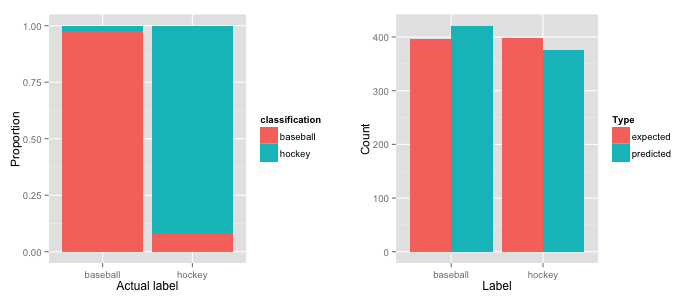

In [50]:
%%R -i df,dfcounts -w 700 -h 300 -u px

df = melt(df)
colnames(df) = c("expected", "value")
df = cbind(df, classification=rep(c('baseball', 'hockey'), 2))

p1 <- ggplot(df, aes(x=expected, y=value, fill=classification)) +
    geom_bar(stat="identity") + 
    xlab("Actual label") +
    ylab("Proportion")


dat = cbind(expected=colSums(dfcounts), predicted=rowSums(dfcounts))
dat = melt(dat)
colnames(dat) <- c("Label", "Type", "Count")

p2 <- ggplot(dat, aes(x=Label, y=Count, fill=Type)) +
    geom_bar(stat="identity", position="dodge")

grid.arrange(p1, p2,
             ncol=2)

In [51]:
terms_baseball = word_counts['baseball'].keys()
terms_hockey = word_counts['hockey'].keys()

print "Total # terms for baseball: ", len(terms_baseball)
print "Total # terms for hockey: ", len(terms_hockey)

Total # terms for baseball:  7439
Total # terms for hockey:  9270


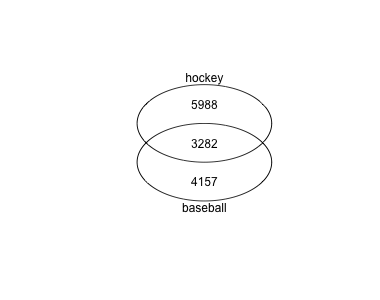

In [52]:
%%R -i terms_baseball,terms_hockey -w 380 -h 300 -u px
venn(list(baseball=terms_baseball, hockey=terms_hockey))